<a href="https://colab.research.google.com/github/catalinapesquet/PINNS-Code-and-Notes/blob/main/PINNS_BurgersEquation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Libraries**

In [2]:
import torch
import torch.autograd as autograd # computation graph
from torch import Tensor # tensor node in the computation graph
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker

from sklearn.model_selection import train_test_split
import numpy as np
import time
import scipy.io

# Auxiliary Functions

In [3]:
def plot3D(x, t, y):
    # Ensure x and t are PyTorch tensors
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    if isinstance(t, np.ndarray):
        t = torch.from_numpy(t)

    # Squeeze tensors to remove extra dimensions
    x_plot = x.squeeze(-1)  # Squeeze the last dimension if necessary
    t_plot = t.squeeze(-1)

    # Create a meshgrid using PyTorch
    T, X = torch.meshgrid(x_plot, t_plot, indexing='ij')  # Explicitly set indexing

    # Ensure y is also a tensor and convert to numpy for plotting
    F_xt = y
    if isinstance(F_xt, torch.Tensor):
        F_xt = F_xt.numpy()

    # Plot the 2D Contour
    fig, ax = plt.subplots(1, 1)
    cp = ax.contourf(T.numpy(), X.numpy(), F_xt, 20, cmap="rainbow")  # Convert T, X to numpy
    fig.colorbar(cp)
    ax.set_title('F(x,t)')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()

    # Plot the 3D Surface
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T.numpy(), X.numpy(), F_xt, cmap="rainbow")  # Convert T, X to numpy
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('f(x,t)')
    plt.show()


In [4]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

# **PINNS for Inverse Problems or "Data driven Discovery of Nonlinear Partial Differential Equations"**

For parameterized and nonlinear partial differential equations of the general form:
$ u_t + N[u;\lambda]= 0 $

where, $u(x,t)$ is the hidden solution and $N[;\lambda]$ is a nonlinear operator parameterized by $\lambda$.


In short: we will use a PINN to get $\lambda$.


Inverse Problem: Data -> Model's paramters so:
Data -> PINN -> Model's parameters (i.e. our PDE parameters).



## Inverse Problems

**Forward Problem**: Model$→$Data (Predict)

**Inverse Problem**: Data→Model (i.e., actually, we get the Model's parameters)

A Neural Network is an example of an inverse problem:

1.   We have an unknown model that follows:

$$N(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

2.   We use our "training" data to get $W_i$ and $b_i$; for $i=1,2,..\#layers$.


Specifically:

Data → Model i.e., estimate our model parameters (i,e., $W_i$ and $b_i$)


## **Problem Setup**

**Burgers' Equation**

Burgers' equation is a fundamental partial differential equation (PDE) that arises in various areas of applied mathematics, including fluid mechanics, nonlinear acoustics, gas dynamics, and traffic flow. In the mechanic field it would be related to the dynamic viscosity.

$$\frac{\partial u}{\partial t}+ \lambda_1u\frac{\partial u}{\partial x}=\lambda_2\frac{\partial^2 u}{\partial x^2} $$

$$x\in[-1,1]$$
$$t\in[0,1]$$

## Analysis:







Let:

$u_t = \frac{\partial u}{\partial t}$

$u_x = \frac{\partial u}{\partial x}$

$u_{xx} = \frac{\partial^2 u}{\partial x^2}$

$\mathscr{N}[u;\lambda]=\lambda_1u u_x-\lambda_2 u_{xx}$

Our PDE is described as:

$$u_t+\lambda_1uu_x=\lambda_2u_{xx}$$

Or,

$$u_t+\mathscr{N}[u;\lambda]=0$$

So we can use a PINN to obtain $\lambda$.

In our case (from the reference solution) $\lambda=[\lambda_1,\lambda_2]=[1,\nu]=\left[1,\frac{1}{100\pi}\right]$

Since N(x,t) is a function, we can obtain its derivatives: $\frac{\partial N}{\partial t},\frac{\partial^2 N}{\partial x^2}, etc.$.(Automatic Diferentiation)

Assume:$$N(t,x)\approx u(t,x)$$

Then:

$$N_t+\lambda_1NN_x-\lambda_2 N_{xx}\approx u_t+uu_x-\lambda u_{xx}=0$$

And:

$$N_t+\lambda_1NN_x-\lambda_2 N_{xx}\approx 0$$


We define this function as $f$:

$$f(t,x)=N_t+\lambda_1NN_x-\lambda_2N_{xx}$$

Remember our operator:

$$f(t,x)=N_t+\mathscr{N}[N,\lambda]$$

So:

$$f(t,x)\approx 0$$


## Loss function

We evaluate $f$ in a certain number of points ($N_u$) inside our domain $(x,t)$. Then we iteratively minimize a loss function related to $f$:

$$MSE_f=\frac{1}{N_u}\sum^{N_u}_{i=1}|f(t_u^i,x_u^i)|^2$$

Usually, the training data set is a set of points from which we know the answer. In our case, points inside our domain (i.e., interior points). **As this is an inverse problem, so we know the data.**

Since we know the outcome, we select $N$ and compute the $MSE_u$** (compare it to the reference solution).

$$MSE_{u}=\frac{1}{N_u}\sum^{N_u}_{i=1}|u(t_{u}^i,x_u^i)-N(t_{u}^i,x_u^i)|^2$$

$$MSE=MSE_{u}+MSE_f$$

NOTE: We minimize $MSE$ to obtain the $N$'s parameters (i.e, $W_i$ and $b_i$) and the ODE parameters (i.e., $\lambda$)→ We will ask our neural network to find our $\lambda$.

# **Data**

In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
# Set default dtype to float32
torch.set_default_dtype(torch.float)

torch.manual_seed(1234)
np.random.seed(1234)

In [7]:
data = scipy.io.loadmat('/content/gdrive/MyDrive/Burgers.mat')

In [8]:
# Let's see the labels
data

# x: spacial domain, usol: real solution, t: temporal domain

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Apr 30 11:20:07 2020',
 '__version__': '1.0',
 '__globals__': [],
 't': array([[0.  ],
        [0.01],
        [0.02],
        [0.03],
        [0.04],
        [0.05],
        [0.06],
        [0.07],
        [0.08],
        [0.09],
        [0.1 ],
        [0.11],
        [0.12],
        [0.13],
        [0.14],
        [0.15],
        [0.16],
        [0.17],
        [0.18],
        [0.19],
        [0.2 ],
        [0.21],
        [0.22],
        [0.23],
        [0.24],
        [0.25],
        [0.26],
        [0.27],
        [0.28],
        [0.29],
        [0.3 ],
        [0.31],
        [0.32],
        [0.33],
        [0.34],
        [0.35],
        [0.36],
        [0.37],
        [0.38],
        [0.39],
        [0.4 ],
        [0.41],
        [0.42],
        [0.43],
        [0.44],
        [0.45],
        [0.46],
        [0.47],
        [0.48],
        [0.49],
        [0.5 ],
        [0.51],
        [0.52],
        

In [9]:
x = data['x']
t = data['t']
usol = data['usol']

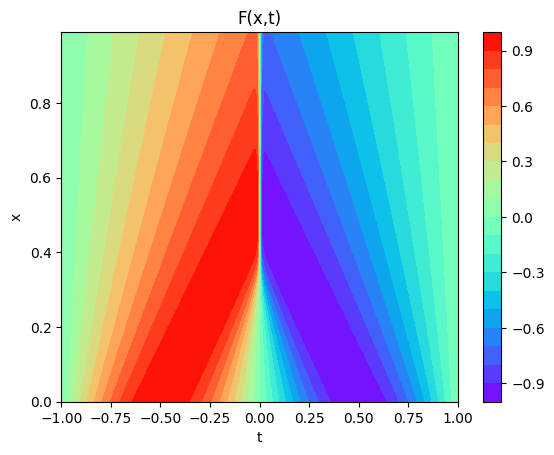

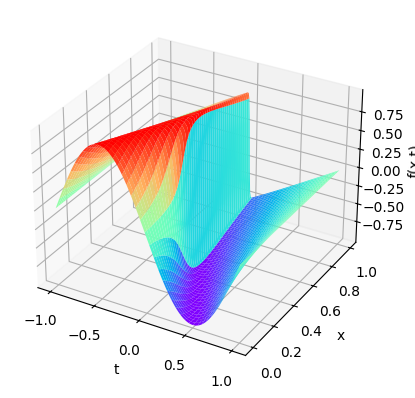

In [10]:
plot3D(x, t, usol)

## Prepare the data

In [11]:
print(x.shape, t.shape)

(256, 1) (100, 1)


In [12]:
X, T = np.meshgrid(x,t)
X.shape, T.shape

((100, 256), (100, 256))

In [13]:
# We need to vectorize our input and output variables
X_true = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
U_true = usol.flatten('F')[:,None]
X_true.shape

(25600, 2)

In [14]:
# lower bound
lb = X_true[0]

# upper bound
ub = X_true[-1]

lb, ub

(array([-1.,  0.]), array([1.  , 0.99]))

## Training data

In [15]:
# how many points we have
total_points = len(x)*len(t)
total_points

25600

In [16]:
N_u = 1000
idx = np.random.choice(total_points, N_u, replace=False)

In [22]:
print("We have",total_points,"points. We will select",X_train_Nu.shape[0],"points to train our model.")

We have 25600 points. We will select 1000 points to train our model.


In [17]:
# Array that contains those random points
X_train_Nu = X_true[idx]
U_train_Nu = U_true[idx]

In [19]:
# Send all arrays to device
X_train_Nu = torch.from_numpy(X_train_Nu).float().to(device)
U_train_Nu = torch.from_numpy(U_train_Nu).float().to(device)
X_true = torch.from_numpy(X_true).float().to(device)
U_true = torch.from_numpy(U_true).float().to(device)

## Initialize our parameters

Our operator is:

$$\mathscr{N}[u;\lambda]=\lambda_1u u_x-\lambda_2 u_{xx}$$

We know that:

$$\lambda_1=1$$

$$\lambda_2=\nu=\frac{1}{100\pi}=0.003183$$

In [28]:
lambda1=2.0
lambda2=0.02

# **Neural Network**



In [ ]:
class FCN():
  def __init__(self, layers):

    'Initiative iterator'
    self.iter = 0
    'Initialize our new parameters i.e. lambda (Inverse problem)'
    self.lambda1 = torch.tensor(lambda1)

In [20]:
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class

        'activation function'
        self.activation = nn.Tanh()

        'Initialize neural network as a list using nn.Modulelist'
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

        'Xavier Normal Initialization'
        for i in range(len(layers)-1):

            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)

            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

    'foward pass'
    def forward(self,x):

        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)

        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)

        #preprocessing input
        x = (x - l_b)/(u_b - l_b) #feature scaling

        #convert to float
        a = x.float()

        for i in range(len(layers)-2):

            z = self.linears[i](a)

            a = self.activation(z)

        a = self.linears[-1](a)

        return a

## Trainning the NN

In [23]:
layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers

In [25]:
PINN = DNN(layers)
PINN

DNN(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1-7): 7 x Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)